In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import os

In [9]:
#print the list of paths of files in the training set
set_path = 'valid'
paths = sorted(glob.glob(f'data/{set_path}/*.hdf5'))
print(paths)

['data/valid/euler_quadrants_gamma_1.13_C3H8_16.0_periodic.hdf5', 'data/valid/euler_quadrants_gamma_1.22_C2H6_15.0_periodic.hdf5', 'data/valid/euler_quadrants_gamma_1.33_H2O_20.0_periodic.hdf5', 'data/valid/euler_quadrants_gamma_1.365_Dry_air_1000.0_periodic.hdf5', 'data/valid/euler_quadrants_gamma_1.3_CO2_20.0_periodic.hdf5', 'data/valid/euler_quadrants_gamma_1.404_H2_100.0_Dry_air_-15.0_periodic.hdf5', 'data/valid/euler_quadrants_gamma_1.453_H2_-76.0_periodic.hdf5', 'data/valid/euler_quadrants_gamma_1.4_Dry_air_20.0_periodic.hdf5', 'data/valid/euler_quadrants_gamma_1.597_H2_-181.0_periodic.hdf5', 'data/valid/euler_quadrants_gamma_1.76_Ar_-180.0_periodic.hdf5']


In [10]:
for p in paths:

    new_p = p.replace('_periodic','')
    new_p = new_p.replace('.0','')
    new_p = new_p.replace('euler_quadrants','euler_multi_quadrants_periodicBC')

    os.rename(p,new_p)
    #print(new_p)


    # with h5py.File(p,'r+') as f:
    #     f.attrs['dataset_name'] = 'euler_multi_quadrants_openBC'
    #     print(f.attrs['dataset_name'])

In [3]:
#select the second path (arbitrary choice)
p = paths[1]

#print the first layer of keys
with h5py.File(p,'r') as f:
    print(f.keys())

<KeysViewHDF5 ['boundary_conditions', 'dimensions', 'scalars', 't0_fields', 't1_fields', 't2_fields']>


In [4]:
# In 'boundary_conditions' is stored the information about the boundary conditions:
with h5py.File(p,'r') as f:
    print('print bc available:', f['boundary_conditions'].keys())
    print('print attributes of the bc:', f['boundary_conditions']['x_periodic'].attrs.keys())
    print('get the bc type:', f['boundary_conditions']['x_periodic'].attrs['bc_type'])

print bc available: <KeysViewHDF5 ['x_periodic', 'y_periodic']>
print attributes of the bc: <KeysViewHDF5 ['associated_dims', 'associated_fields', 'bc_type', 'sample_varying', 'time_varying']>
get the bc type: PERIODIC


In [5]:
#Reminder: 't0_fields', 't1_fields', 't2_fields' are respectively scalar fields, vector fields and tensor fields
#print the different fields available in the dataset
with h5py.File(p,'r') as f:
    print('t0_fields:', f['t0_fields'].keys())
    print('t1_fields:', f['t1_fields'].keys())
    print('t2_fields:', f['t2_fields'].keys())

t0_fields: <KeysViewHDF5 ['density', 'energy', 'pressure']>
t1_fields: <KeysViewHDF5 ['momentum']>
t2_fields: <KeysViewHDF5 []>


In [6]:
#The data is of shape (n_trajectories, n_timesteps, x, y)
traj = 50
#Get the first t0_field and save it as a numpy array
with h5py.File(p,'r') as f:
    density = f['t0_fields']['density'][traj,...] #HDF5 datasets can be sliced like a numpy array. As the file is large, we directly select the trajectory
    print(f'shape of the selected t0_field: ',density.shape)   
    #you can directly slice the selected field without reading the whole dataset by doing:
    #traj = 0 #select the trajectory
    # field = f['t0_fields']['concentration'][traj, :] 

shape of the selected t0_field:  (101, 512, 512)


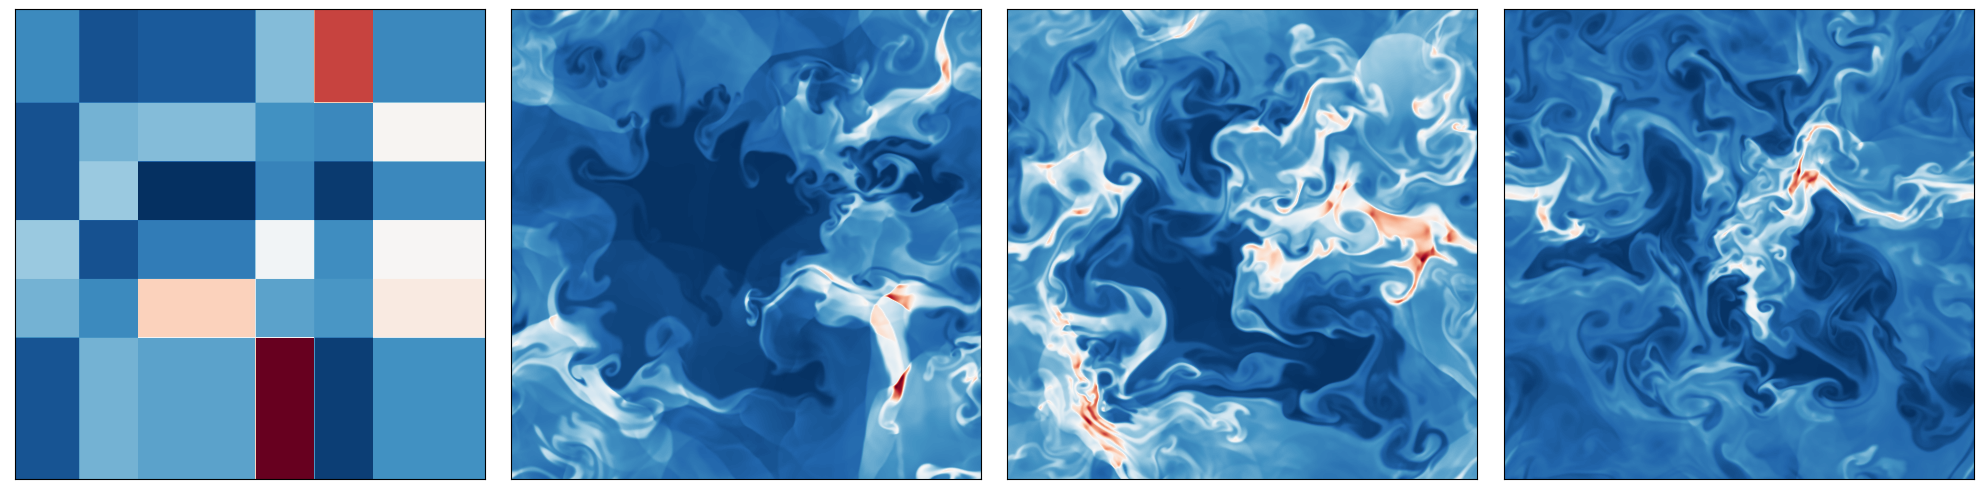

In [13]:
#field is now of shape (n_timesteps, x, y). Let's do a subplot to plot it at t= 0, t= T/3, t= 2T/3 and t= T:
fig, axs = plt.subplots(1, 4, figsize=(20,5))
T = density.shape[0]
#fix colorbar for all subplots:
vmin = np.min(density)
vmax = np.max(density)
normm = True
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cmap = 'RdBu_r'
for i, t in enumerate([0, T//3, (2*T)//3, T-1]):
    axs[i].imshow(density[t], cmap=cmap)#, norm = norm)
    #plt.colorbar(plt.cm.ScalarMappable( cmap='viridis'), ax=axs[i], orientation='horizontal')
    #axs[i].set_title(f't={t}')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.tight_layout()


In [14]:
#save figure without axes and titles:

image_name = 'euler_quadrants_periodic_unnormalized'
path_to_save = '/mnt/home/polymathic/ceph/the_well/viz/'
fig.savefig(f'{path_to_save}{image_name}.png', bbox_inches='tight', pad_inches=0.05)

In [15]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm
def create_gif(time_series, saving_directory, name_file = 'concentration', delete_imgs=False, normalize = True):
    time_series_min = time_series.min()
    time_series_max = time_series.max()
    if time_series.ndim > 3:
        #error:
        print('Error: The time series should be (time, height, width)')
        return
    if not os.path.exists(saving_directory + '/img_for_gif'):
        os.makedirs(saving_directory + '/img_for_gif')
    images = []
    cmap = 'RdBu_r' #'viridis'
    for i in range(time_series.shape[0]):
        if normalize:
            plt.imshow(time_series[i], origin='lower',cmap=cmap, vmin=time_series_min, vmax=time_series_max);
        else:
            plt.imshow(time_series[i], cmap=cmap, origin='lower')#, vmin=time_series_min, vmax=time_series_max);
        #plt.show()
        plt.axis('off')
        plt.savefig(saving_directory + f'/img_for_gif/time_series_{i}.png', bbox_inches='tight', pad_inches=0)
        plt.close()
        images.append(imageio.imread(saving_directory + f'/img_for_gif/time_series_{i}.png'))

    imageio.mimsave(saving_directory + '/' + name_file + '.gif', images, duration=0.1)
    if delete_imgs:
        shutil.rmtree(saving_directory + '/img_for_gif')

In [17]:
create_gif(density, 'gif', name_file='density_normalized', delete_imgs=True, normalize = True)

/tmp/ipykernel_3630257/3636312021.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(saving_directory + f'/img_for_gif/time_series_{i}.png'))
